In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import datasets, layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
n = 5000
train_images = train_images[:n]
train_labels = train_labels[:n]

What does this data look like? 

In [4]:
train_images.shape

(5000, 32, 32, 3)

In [5]:
train_images[0,:5,:5, 0]

array([[ 59,  43,  50,  68,  98],
       [ 16,   0,  18,  51,  88],
       [ 25,  16,  49,  83, 110],
       [ 33,  38,  87, 106, 115],
       [ 50,  59, 102, 127, 124]], dtype=uint8)

The train set consists of 50000 images of 32x32 pixels, with 3 channels (r,g,b values). The r,g,b values are between 0 and 255. For input of Neural networks, it is better to have small input values. So we normalize our data between 0 and 1: (nb: can also do this with a Rescaling layer)

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

The labels are single numbers denoting the class:

In [7]:
train_labels.shape

(5000, 1)

In [8]:
train_labels[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

Plot some examples. We map the class numbers back to the class names

In [9]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

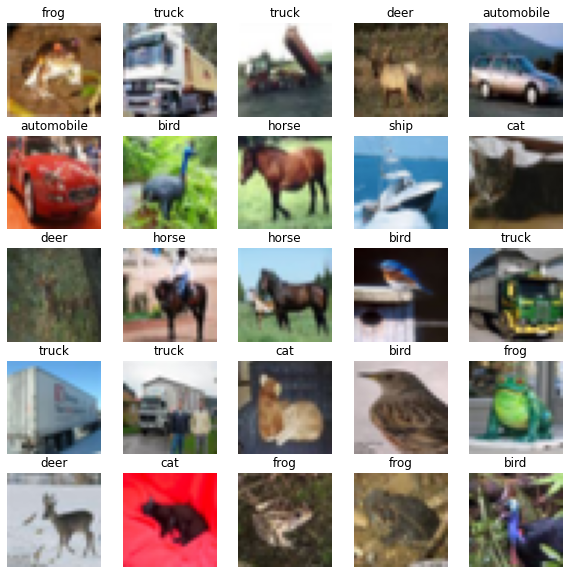

In [25]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.axis('off')
    plt.title(class_names[train_labels[i,0]])
plt.show()

In the previous episodes, we used 'fully connected layers' , that connected all input values to all hidden nodes. This results in many connections, and thus weights to be learned, in the network. Note that our input dimension is now quite high (even with small pictures), we have:

In [11]:
dim = train_images.shape[1] * train_images.shape[2] * train_images.shape[3]
print(dim)

3072


suppose we create one hidden layer with the same dimension, we get a number of weights:

In [12]:
dim * dim

9437184

Moreover, if we increase the image size, this number of weights will explode. However, we want the network to learn in a 'smart' way: the same type of features apply for small and for large images, and at any place in the image. (Explain shortly about traditional feature based image analysis).
That's where *convolutional* and *pooling* layers come into play. (explain what these layers do)

In [13]:
inputs = keras.Input(shape=train_images.shape[1:])
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="cifar_model")

In [14]:
model.summary()

Model: "cifar_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              

Note how the number of parameters is much lower than we would have with only one dense layer of the same shape of our convolutional layer

Let's compile and train the model

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(test_images, test_labels))

Epoch 1/20
157/157 [==============================] - 11s 73ms/step - loss: 2.0979 - accuracy: 0.2200 - val_loss: 1.8622 - val_accuracy: 0.3207
Epoch 2/20
157/157 [==============================] - 15s 95ms/step - loss: 1.7638 - accuracy: 0.3578 - val_loss: 1.6595 - val_accuracy: 0.3925
Epoch 3/20
157/157 [==============================] - 16s 103ms/step - loss: 1.6066 - accuracy: 0.4106 - val_loss: 1.5562 - val_accuracy: 0.4294
Epoch 4/20
157/157 [==============================] - 22s 138ms/step - loss: 1.4860 - accuracy: 0.4598 - val_loss: 1.5033 - val_accuracy: 0.4623
Epoch 5/20
157/157 [==============================] - 23s 149ms/step - loss: 1.4306 - accuracy: 0.4906 - val_loss: 1.5352 - val_accuracy: 0.4416
Epoch 6/20
157/157 [==============================] - 23s 147ms/step - loss: 1.3435 - accuracy: 0.5156 - val_loss: 1.4855 - val_accuracy: 0.4738
Epoch 7/20
157/157 [==============================] - 18s 118ms/step - loss: 1.2770 - accuracy: 0.5376 - val_loss: 1.4057 - val_accu

313/313 - 2s - loss: 1.9951 - accuracy: 0.4848


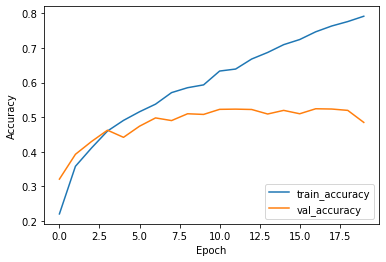

In [24]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

Note that the training accuracy continues to increase, while the validation accuracy stagnates over the course of the epochs. This means we are overfitting on our training data set.

There are several ways of preventing overfitting, called regularization methods.
One common and simple method is Dropout. (explain how and why dropout works)

Let's add one dropout layer towards the end of the network, that randomly drops 20% of the input units

In [18]:
inputs = keras.Input(shape=train_images.shape[1:])
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10)(x)

model_dropout = keras.Model(inputs=inputs, outputs=outputs, name="cifar_model")

In [21]:
model_dropout.summary()

Model: "cifar_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          

In [19]:
model_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_dropout = model_dropout.fit(train_images, train_labels, epochs=20, 
                    validation_data=(test_images, test_labels))

Epoch 1/20
157/157 [==============================] - 38s 244ms/step - loss: 2.0695 - accuracy: 0.2220 - val_loss: 1.8932 - val_accuracy: 0.3061
Epoch 2/20
157/157 [==============================] - 40s 254ms/step - loss: 1.8050 - accuracy: 0.3410 - val_loss: 1.8429 - val_accuracy: 0.3239
Epoch 3/20
157/157 [==============================] - 45s 287ms/step - loss: 1.6956 - accuracy: 0.3768 - val_loss: 1.6203 - val_accuracy: 0.3968
Epoch 4/20
157/157 [==============================] - 53s 340ms/step - loss: 1.6023 - accuracy: 0.4144 - val_loss: 1.6138 - val_accuracy: 0.4124
Epoch 5/20
157/157 [==============================] - 40s 255ms/step - loss: 1.5106 - accuracy: 0.4474 - val_loss: 1.5690 - val_accuracy: 0.4313
Epoch 6/20
157/157 [==============================] - 31s 199ms/step - loss: 1.4472 - accuracy: 0.4746 - val_loss: 1.4594 - val_accuracy: 0.4619
Epoch 7/20
157/157 [==============================] - 32s 206ms/step - loss: 1.3765 - accuracy: 0.5096 - val_loss: 1.4193 - val_ac

313/313 - 2s - loss: 1.4683 - accuracy: 0.5307


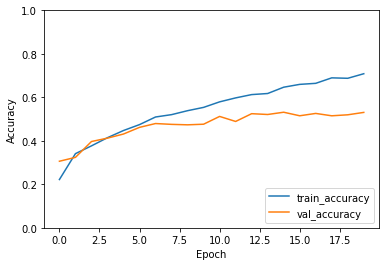

In [22]:
plt.plot(history_dropout.history['accuracy'], label='train_accuracy')
plt.plot(history_dropout.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_dropout.evaluate(test_images,  test_labels, verbose=2)

Now we see that the gap between the training accuracy and validation accuracy is much smaller, and that the final accuracy on the validation set is higher than without dropout.